# Machine Learning Poject

In [1]:
import sys
print(sys.executable)

c:\Users\raphp\.conda\envs\ML_env\python.exe


# Project Overview

This project presents an end-to-end workflow on a real-world satellite imagery dataset — from exploratory analysis to predictive modeling and weakly supervised segmentation.

## Task

The main goal of this project is to automatically detect and localize airplanes in satellite images.  
The problem is first approached as a **binary classification task** — determining whether a given 20×20 image tile contains an airplane or not — and later extended to a **segmentation task**, aiming to identify the exact regions where airplanes appear in full satellite scenes.

## Workflow

- **Explore & understand** the dataset structure and class distribution.  
- **Preprocess & clean** the data to make it suitable for analysis.  
- **Build & evaluate** machine learning and deep learning models for classification.  
- **Extend** the approach toward detection and segmentation using CNNs and Grad-CAM methods.  
- **Analyze** the results through quantitative metrics and visual inspection.

## Methodology

We follow a rigorous process, detailing each step from data preparation to model evaluation, explaining why each choice is made, how it is implemented, and what conclusions are drawn at every stage.  
This includes both traditional feature-based methods (SVM, Random Forest) and deep learning architectures (CNN, ResNet).

## Objective

Beyond raw performance, our objective is to develop a **structured and critical analysis** of computer vision techniques applied to satellite imagery,  
highlighting their strengths, limitations, and the challenges of real-world data such as class imbalance and variability in lighting or scale.

## Topic choice

As engineering students in **Industry & Robotics – Aerospace & Defense**, we wanted to work on a subject close to real-world applications and our academic track.  
After working with tabular datasets in previous projects, we decided to focus on **image-based data** to strengthen our understanding of computer vision and machine learning.  
Following extensive research, we selected the **PlanesNet** dataset for its quality, accessibility, and relevance to modern satellite surveillance problems.


# Data Exploration

# Dataset loading and imports

In this part, our goal is to check the **overall health of the dataset** like its structure, number of images, label consistency, and file integrity.  
These checks are essential before starting any kind of manipulation or data exploration.

In [2]:
# CORE IMPORTS
import os
import kagglehub
import glob
import random
import shutil
import zipfile

from pathlib import Path
from PIL import Image
from collections import Counter

# NUMERICS AND DATA HANDLING
import numpy as np
import pandas as pd

# IMAGE PROCESSING
import cv2

# VISUALIZATION
import matplotlib.pyplot as plt

#SKLEARN
from sklearn.model_selection import train_test_split

## Dataset Loading

In this step, we download and explore the **PlanesNet dataset** to check its internal structure and confirm that all files are correctly organized.  
This verification ensures that we can load and use the data properly in the following stages.

In [3]:
from kaggle import api
from pathlib import Path
import shutil

# Create "planesnet" folder next to the notebook (relative path)
path = Path("planesnet")
path.mkdir(exist_ok=True)

# Clean folder content if it already exists
for item in path.iterdir():
    if item.is_file() or item.is_symlink():
        item.unlink()
    elif item.is_dir():
        shutil.rmtree(item)

# Download & unzip the dataset
api.dataset_download_files("rhammell/planesnet", path=str(path), unzip=True)

# Display a few files to confirm
print("Dataset downloaded in:", path.resolve())
print("\nSample files:")
for i, p in enumerate(path.rglob("*")):
    if i > 10: break
    print(" -", p.relative_to(path))


Dataset URL: https://www.kaggle.com/datasets/rhammell/planesnet
Dataset downloaded in: C:\ESILV\A4\Machine_learning\Projet\planesnet

Sample files:
 - planesnet
 - planesnet.json
 - scenes
 - planesnet\planesnet
 - planesnet\planesnet\0__20140723_181317_0905__-122.073653222_37.7090043618.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.083122783_37.7221653245.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.105473207_37.6723685004.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.1075857442429_37.643668625142496.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.14328662_37.697282118.png
 - planesnet\planesnet\0__20140723_181317_0905__-122.166243758_37.6649723192.png
 - planesnet\planesnet\0__20140723_181318_0905__-122.109032733_37.7274203173.png


Once the dataset is downloaded, we inspect its folder structure to confirm the organization of files and subfolders

## Folders architecture

In [4]:
for root, dirs, files in os.walk(path):
    print(root)

planesnet
planesnet\planesnet
planesnet\planesnet\planesnet
planesnet\scenes
planesnet\scenes\scenes


After exploring the main folder, we observed that the dataset contains **two main directories**:
- `planesnet` → Cointain the image tiles used for our classification.  
- `scenes` → includes larger satellite scenes, used later in the project.

To simplify access to the training images, we store their path in a variable.

In [5]:
dataset_images = os.path.join(path, "planesnet\planesnet")#chemin d'acces du dataset

print("\nTrain images dir :", dataset_images)


Train images dir : planesnet\planesnet\planesnet


Next, we verify the number of images inside the dataset to ensure that all files are properly loaded.

In [6]:
images_count = len(os.listdir(dataset_images))

print(f"Nnumber of images in the dataset folder: {images_count} ")

Nnumber of images in the dataset folder: 32000 


We indeed have 32k images in our dataset, but this information is still too vague.  
We now need to take a closer look at how many images belong to each of our two classes.

In [7]:
# 1.1 – Inspection des noms de fichiers 

# Liste les 5 premiers fichiers du dataset
sample_images = sorted(os.listdir(dataset_images))[:5]
print("Nom de fichierdans le data set :")
for name in sample_images:
    print("-", name)


Nom de fichierdans le data set :
- 0__20140723_181317_0905__-122.073653222_37.7090043618.png
- 0__20140723_181317_0905__-122.083122783_37.7221653245.png
- 0__20140723_181317_0905__-122.105473207_37.6723685004.png
- 0__20140723_181317_0905__-122.1075857442429_37.643668625142496.png
- 0__20140723_181317_0905__-122.14328662_37.697282118.png


As mentioned in the dataset description, the image filenames follow a well-defined structure:  

Each individual image filename follows the format:  
`{label}_{scene_id}_{longitude}_{latitude}.png`

- **label** → Takes the value `1` or `0`, representing the *“plane”* and *“no-plane”* classes, respectively.  
- **scene_id** → The unique identifier of the PlanetScope visual scene from which the image was extracted. This ID can be used with the Planet API to locate and download the complete scene.  
- **longitude_latitude** → The geographic coordinates (longitude and latitude) of the image’s center point, separated by a single underscore.


# Quantitative data exploration


## Data balance

Now that the dataset is loaded, we can begin the **exploration phase** by checking the balance between the two classes.  
It is important to verify that one class (for example, “plane”) is not overly represented compared to the other.  
To do this, we extract the first character of each filename, which indicates the label (0 or 1).


In [8]:
image_files = [f for f in os.listdir(dataset_images) if f.endswith('.png')]# liste des nom des 32k d'images
labels = [f[0] for f in image_files]  # on prend juste le premier caractère

nbr0 = labels.count('0')
nbr1 = labels.count('1')

print("Number of non plane images(label 0) =", nbr0, nbr0/images_count*100 , "% -  Number of plane images(label 1) =", nbr1, nbr1/images_count*100,"%")

Number of non plane images(label 0) = 24000 75.0 % -  Number of plane images(label 1) = 8000 25.0 %


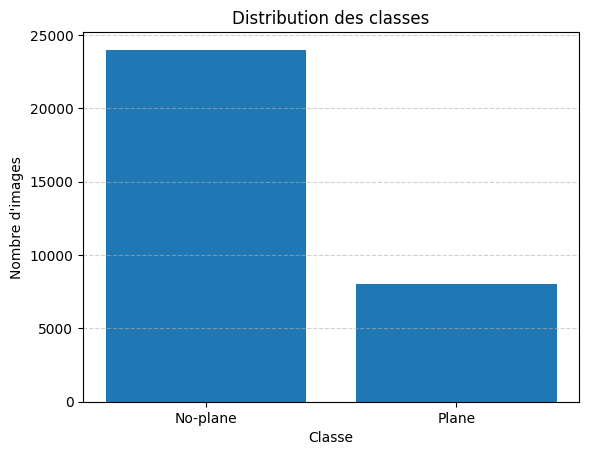

In [9]:
df_counts = pd.DataFrame({
    "Class": ["No-plane", "Plane"],
    "Count": [nbr0, nbr1]  # ou [len(files_0), len(files_1)] selon ton code précédent
})

plt.figure()
plt.bar(df_counts["Class"], df_counts["Count"])
plt.title("Distribution des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

The previous step confirmed that our dataset is imbalanced, with about **three times more non-plane images** than plane images.  
This is an important observation, as it may require applying rebalancing techniques such as **SMOTE** or class weighting during model training.

Before diving into modeling, we can visually inspect a few random samples from both classes to better understand the image content and variability.

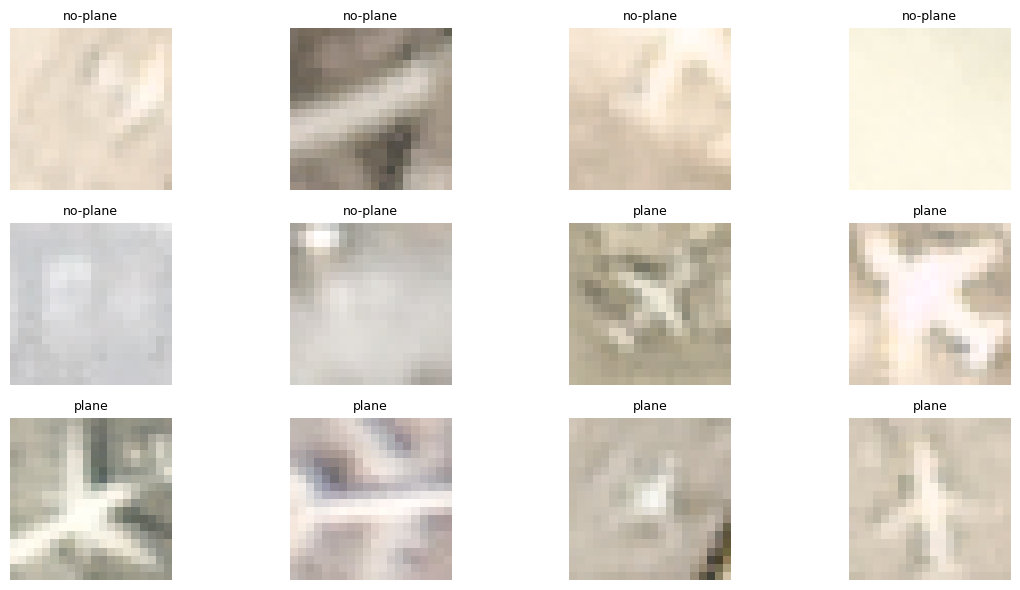

In [10]:

import os, random
import matplotlib.pyplot as plt
from PIL import Image

all_files = [f for f in os.listdir(dataset_images) if f.endswith(".png")]
files_0 = [f for f in all_files if f[0] == "0"]
files_1 = [f for f in all_files if f[0] == "1"]

sample0 = random.sample(files_0, k=min(6, len(files_0)))
sample1 = random.sample(files_1, k=min(6, len(files_1)))
samples = [(f, "no-plane") for f in sample0] + [(f, "plane") for f in sample1]

plt.figure(figsize=(12, 6))
for i, (fname, cls) in enumerate(samples, 1):
    img = Image.open(os.path.join(dataset_images, fname)).convert("RGB")
    plt.subplot(3, 4, i); plt.imshow(img); plt.axis("off"); plt.title(cls, fontsize=9)
plt.tight_layout(); plt.show()


Here’s a preview of our dataset: small image tiles that either capture **aircraft** or **ground** surfaces.  
These samples help us get an initial sense of what the model will learn to distinguish.